In [6]:
%%time
from pymongo import MongoClient
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from sklearn.cluster import KMeans
import numpy as np
import pickle
import time

#start_time = time.time()

client=MongoClient()
client=MongoClient('mongodb://localhost:/')
db=client['eventData']
sen=db.documents_arabic

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('ar')
en_stop.append(' ب')
en_stop.append('إلى')
en_stop.append('إلى')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

texts = []
docIds=[]
actuallyTrained=0;
for i in sen.find():
    try:
        raw = ''.join(i['document']).lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
        docIds.append(i['_id'])
        actuallyTrained=actuallyTrained+1
    except:
        pass

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=1)

dim=20 
result=[]
for i in range(0,actuallyTrained):
    feature=[]
    previousindex=0
    for item in ldamodel[corpus[i]]:
        index=item[0]
        #print(index)
        for beforeindex in range(previousindex,index):
            feature.append(0)
        feature.append(item[1])
        previousindex=index+1
    while (len(feature)<dim):
        feature.append(0);  #add in 0 at the end
    result.append(feature)
    
kmeanstest=np.array(result)
kmeans = KMeans(n_clusters=20, random_state=0).fit(kmeanstest)

#and before building  the dictionary test if the size of docIds and cluster result dimensions are the same.
try:
    assert(len(docIds)==kmeans.labels_.size)
    dictionary_cocId_topicClusterItBelongs={}
    for i in range(0,actuallyTrained):
        dictionary_cocId_topicClusterItBelongs.update({docIds[i]:kmeans.labels_[i]})
except:
    print("the docIds size is different from the topic # cluster size")

with open('traingrst_arabic.pkl', 'wb') as output:
    pickle.dump(dictionary_cocId_topicClusterItBelongs,output)

#print("--- %s seconds ---" % (time.time() - start_time))



CPU times: user 41min 10s, sys: 2h 48s, total: 2h 41min 59s
Wall time: 31min 34s


#store the topic of the sentence to database.

In [1]:
%%time
from pymongo import MongoClient
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from sklearn.cluster import KMeans
import numpy as np
import pickle
import time

#start_time = time.time()

client=MongoClient()
client=MongoClient('mongodb://localhost:29017/')
db=client['eventData']
sen=db.documents_arabic

CPU times: user 660 ms, sys: 1.12 s, total: 1.78 s
Wall time: 644 ms


In [10]:
%%time
dic=pickle.load(open('traingrst_arabic.pkl', 'rb'))
topic_set=0;
for i in sen.find(modifiers={"$snapshot": True}):
    try:
        #find the topic from the dictionary
        docid=i['_id']
        topic=dic[docid]
        #print(topic)
        sen.update_many(
        {"_id": str(docid)},
        {
        "$set": {
            #this need to cast to int, otherwise it has a can't encode object error after it use pickle to load.
            "topic":int(topic)
        }
        }
        )
        topic_set=topic_set+1
    except Exception as e:
        print(str(e))
        pass
print(topic_set)

86253
CPU times: user 16.5 s, sys: 1.87 s, total: 18.4 s
Wall time: 28.9 s


In [38]:
from bson.son import SON
pipeline = [
     {"$unwind": "$topic"},
     {"$group": {"_id": "$topic", "count": {"$sum": 1}}},
     {"$sort": SON([("count", -1), ("_id", -1)])}
 ]
import pprint
distribution=list(db.documents_arabic.aggregate(pipeline))

In [39]:
distribution

[{'_id': 0, 'count': 10310},
 {'_id': 15, 'count': 5631},
 {'_id': 4, 'count': 5432},
 {'_id': 12, 'count': 5156},
 {'_id': 16, 'count': 4808},
 {'_id': 7, 'count': 4779},
 {'_id': 6, 'count': 4534},
 {'_id': 2, 'count': 4254},
 {'_id': 19, 'count': 4169},
 {'_id': 10, 'count': 4167},
 {'_id': 17, 'count': 4050},
 {'_id': 9, 'count': 3963},
 {'_id': 3, 'count': 3951},
 {'_id': 14, 'count': 3778},
 {'_id': 18, 'count': 3732},
 {'_id': 13, 'count': 3471},
 {'_id': 11, 'count': 2918},
 {'_id': 5, 'count': 2742},
 {'_id': 1, 'count': 2736},
 {'_id': 8, 'count': 1672}]

In [46]:
xpos=[]
ypos=[]
for dictitem in distribution:
    xpos.append(dictitem['_id'])
    ypos.append(dictitem['count'])

In [47]:
xpos

[0, 15, 4, 12, 16, 7, 6, 2, 19, 10, 17, 9, 3, 14, 18, 13, 11, 5, 1, 8]

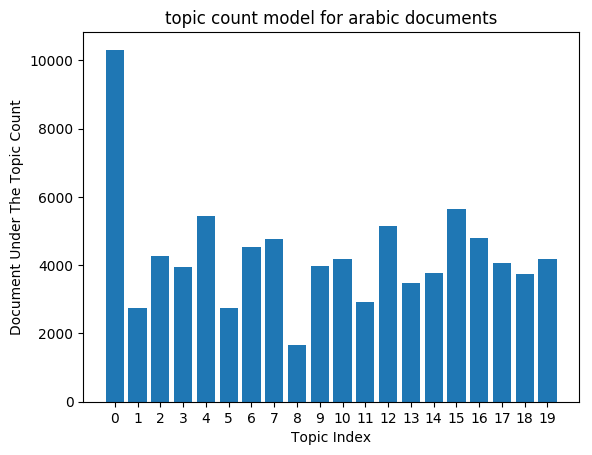

In [52]:
import matplotlib.pyplot as plt; 
plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#performance = [10,8,6,4,2,1]
plt.bar(xpos, ypos)
#plt.xticks(y_pos, objects)
plt.ylabel('Document Under The Topic Count')
plt.xlabel('Topic Index')
plt.xticks(np.arange(0, 20, 1))
plt.title('topic count model for arabic documents')
plt.show()